In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the path to the folder you want to access
folder_path = "/content/drive/My Drive/Machine_Learning_24/Final_project/predict-energy-behavior-of-prosumers/"

# List the content of the folder
!ls "$folder_path"

client.csv		    example_test_files	    public_timeseries_testing_util.py
county_id_to_name_map.json  forecast_weather.csv    train.csv
electricity_prices.csv	    gas_prices.csv	    weather_station_to_county_mapping.csv
enefit			    historical_weather.csv


In [ ]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)



In [ ]:
# !pip install verstack
# from verstack import LGBMTuner

In [ ]:
def generate_featuers(
    df_data,
    df_client,
    df_gas_prices,
    df_electricity_prices,
    df_forecast_weather,
    df_historical_weather,
    df_weather_station_to_county_mapping,
    train_start_timestep = '2021-09-01 11:00:00',
    gas_end_date = '2022-01-10 23:00:00'

    ):

    df_weather_station_to_county_mapping = df_weather_station_to_county_mapping[df_weather_station_to_county_mapping.notnull().all(axis=1)].sort_values(by="county")
    result_dict = dict(zip(zip(round(df_weather_station_to_county_mapping['latitude'],1), round(df_weather_station_to_county_mapping['longitude'],1)), df_weather_station_to_county_mapping['county']))

    df_historical_weather = df_historical_weather[df_historical_weather['datetime'] >= train_start_timestep]


    #Merge df_data and df_client
    df_client_try = df_client.copy(deep=True)
    df_client_try['date'] = pd.to_datetime(df_client_try['date'])
    df_client_try['datetime'] = df_client_try['date'].apply(lambda x: [x + pd.Timedelta(hours=i) for i in range(24)])
    df_client_try = df_client_try.explode('datetime')
    df_client_try = df_client_try.drop(['date','data_block_id'], axis=1)

    df_data['datetime'] = pd.to_datetime(df_data['datetime'])
    df_data = df_data.merge(df_client_try, on=['county','product_type','is_business','datetime'], how='left')

    endDate = df_client_try['datetime'].max()
    df_data = df_data[df_data['datetime'] <= endDate]


    #Merge df_data and df_gas_prices
    df_gas_try = df_gas_prices.copy(deep=True)
    df_gas_try['forecast_date'] = pd.to_datetime(df_gas_try['forecast_date'])
    df_gas_try['datetime'] = df_gas_try['forecast_date'].apply(lambda x: [x + pd.Timedelta(hours=i) for i in range(24)])
    df_gas_try = df_gas_try.explode('datetime')
    df_gas_try = df_gas_try.drop(['forecast_date' , 'origin_date' , 'data_block_id'], axis=1)
    gas_end_date = df_gas_try['datetime'].max()
    df_data = df_data[df_data['datetime'] <= gas_end_date]
    df_data = df_data.merge(df_gas_try, on=['datetime'], how='left')

    #Merge df_data and df_electricity_prices
    df_electricity_prices_try = df_electricity_prices.copy(deep=True)
    df_electricity_prices_try.drop(columns=["origin_date" , 'data_block_id'], inplace=True)
    df_electricity_prices_try['forecast_date'] = pd.to_datetime(df_electricity_prices_try['forecast_date'])
    df_electricity_prices_try.rename(columns={"forecast_date": "datetime"}, inplace=True)
    df_data = df_data.merge(df_electricity_prices_try, on=['datetime'], how='left')

    #Merge df_data and df_forecast_weather
    df_forecast_weather_copy = df_forecast_weather.copy(deep=True)
    df_forecast_weather_copy['county'] = [result_dict.get((x, y), -1) for x, y in zip(df_forecast_weather_copy['latitude'], df_forecast_weather_copy['longitude'])]
    df_forecast_weather_copy = df_forecast_weather_copy[df_forecast_weather_copy['county']!=-1]
    df_forecast_weather_copy['origin_datetime'] = pd.to_datetime(df_forecast_weather_copy['origin_datetime'])
    df_forecast_weather_copy['origin_datetime'] = pd.to_datetime(df_forecast_weather_copy['origin_datetime'].dt.date.astype(str) + ' 02:00:00')
    df_forecast_weather_copy['forecast_datetime'] = df_forecast_weather_copy['origin_datetime'] + pd.to_timedelta(df_forecast_weather_copy['hours_ahead'], unit='h')
    df_forecast_weather_copy = df_forecast_weather_copy.drop('origin_datetime',axis=1)
    df_forecast_weather_copy = df_forecast_weather_copy.sort_values(by=['latitude','longitude','forecast_datetime', 'hours_ahead'])
    df_forecast_weather_copy['cumcount'] = (df_forecast_weather_copy['hours_ahead']-1)//24+1

    columns_to_average = [col for col in df_forecast_weather_copy.columns if col not in ['latitude', 'longitude', 'hours_ahead' , 'forecast_datetime','cumcount']]
    agg_dict = {col: 'mean' for col in columns_to_average}
    agg_dict['cumcount'] = 'first'  # to preserve the cumcount value
    df_forecast_weather_copy = df_forecast_weather_copy.groupby(['county','forecast_datetime', 'cumcount']).agg(agg_dict)
    df_forecast_weather_copy=df_forecast_weather_copy.unstack(level=-1)
    df_forecast_weather_copy.columns = [f'{col[0]}_{col[1]}' for col in df_forecast_weather_copy.columns]
    df_forecast_weather_copy.reset_index(inplace=True)
    df_forecast_weather_copy.rename(columns={'forecast_datetime': 'datetime'}, inplace=True)
    df_forecast_weather_copy = df_forecast_weather_copy.drop(['county_1','county_2','cumcount_1','cumcount_2'],axis=1)
    df_forecast_weather_copy.fillna(0, inplace=True)

    df_data = df_data.merge(df_forecast_weather_copy, on=['county','datetime'], how='left')


    #Merge df_data and df_historical_weather
    df_historical_weather_copy = df_historical_weather.copy(deep=True)
    df_historical_weather_copy['datetime'] = pd.to_datetime(df_historical_weather_copy['datetime'])
    df_historical_weather_copy['county'] = [result_dict.get((x, y), -1) for x, y in zip(df_historical_weather_copy['latitude'], df_historical_weather_copy['longitude'])]
    df_historical_weather_copy = df_historical_weather_copy[df_historical_weather_copy['county']!=-1]
    df_historical_weather_copy = df_historical_weather_copy.sort_values(by=['latitude','longitude','datetime'])
    columns_to_average = [col for col in df_historical_weather_copy.columns if col not in ['latitude', 'longitude', 'datetime','county','data_block_id']]
    agg_dict = {col: 'mean' for col in columns_to_average}
    df_historical_weather_copy = df_historical_weather_copy.groupby(['county','datetime']).agg(agg_dict)
    df_historical_weather_copy.reset_index(inplace=True)

    df_data = df_data.merge(df_historical_weather_copy, on=['county','datetime'], how='left')

    return df_data

In [ ]:
DATA_DIR = folder_path
# Read CSVs and parse relevant date columns
df_data = pd.read_csv(DATA_DIR + "train.csv")
df_client = pd.read_csv(DATA_DIR + "client.csv")
df_historical_weather = pd.read_csv(DATA_DIR + "historical_weather.csv")
df_forecast_weather = pd.read_csv(DATA_DIR + "forecast_weather.csv")
df_electricity_prices = pd.read_csv(DATA_DIR + "electricity_prices.csv")
df_gas_prices = pd.read_csv(DATA_DIR + "gas_prices.csv")
df_weather_station_to_county_mapping = pd.read_csv(DATA_DIR + "weather_station_to_county_mapping.csv")

In [ ]:
combined_df = generate_featuers(
    df_data,
    df_client,
    df_gas_prices,
    df_electricity_prices,
    df_forecast_weather,
    df_historical_weather,
    df_weather_station_to_county_mapping)

In [ ]:
print(combined_df.columns)


Index(['county', 'is_business', 'product_type', 'target', 'is_consumption',
       'datetime', 'data_block_id', 'row_id', 'prediction_unit_id',
       'eic_count', 'installed_capacity', 'lowest_price_per_mwh',
       'highest_price_per_mwh', 'euros_per_mwh', 'temperature_1',
       'temperature_2', 'dewpoint_1', 'dewpoint_2', 'cloudcover_high_1',
       'cloudcover_high_2', 'cloudcover_low_1', 'cloudcover_low_2',
       'cloudcover_mid_1', 'cloudcover_mid_2', 'cloudcover_total_1',
       'cloudcover_total_2', '10_metre_u_wind_component_1',
       '10_metre_u_wind_component_2', '10_metre_v_wind_component_1',
       '10_metre_v_wind_component_2', 'data_block_id_1', 'data_block_id_2',
       'direct_solar_radiation_1', 'direct_solar_radiation_2',
       'surface_solar_radiation_downwards_1',
       'surface_solar_radiation_downwards_2', 'snowfall_1', 'snowfall_2',
       'total_precipitation_1', 'total_precipitation_2', 'temperature',
       'dewpoint', 'rain', 'snowfall', 'surface_pressu

In [ ]:
import plotly.express as px
product_type = 3
is_business = 0
county = 0
is_consumption = 1

df_plot = combined_df[
    (combined_df['is_business'] == is_business)
    & (combined_df['is_consumption'] == is_consumption)
    & (combined_df['product_type'] == product_type)
    & (combined_df['county'] == county)
]

fig = px.line(
    df_plot,
    x="datetime",
    y="target",
    color='county',
    title=f'Target for is_busines={is_business}, is_consumption={is_consumption}, product_type={product_type}'
)
fig.show()

In [ ]:
combined_df = generate_featuers(
    df_data,
    df_client,
    df_gas_prices,
    df_electricity_prices,
    df_forecast_weather,
    df_historical_weather,
    df_weather_station_to_county_mapping)

In [ ]:
combined_df

In [ ]:
# Assuming combined_df is already defined and has the "target" column
import pandas as pd

# Make a copy of the DataFrame
combined_df_copy = combined_df.copy()

# Define the day offsets you want to use
day_offsets = [1, 2, 3, 4, 5, 6, 7, 14]

# Define the base join condition
join_condition = ["county", "is_business", "product_type", "is_consumption"]

# Function to add shifted columns for each group
def add_shifted_columns(group):
    for i, offset in enumerate(day_offsets, start=1):
        # Compute the target column name dynamically
        target_column_name = f"target_{i}"

        # Compute the shifted column with negative offset
        shifted_column = group["target"].shift(periods=offset)

        # Add the shifted column to the DataFrame
        group[target_column_name] = shifted_column
    return group

# Apply the function to each group defined by the join condition
combined_df_copy = combined_df_copy.groupby(join_condition).apply(add_shifted_columns)

# Drop the last columns with NaNs if necessary
# combined_df_copy = combined_df_copy.dropna(subset=[f"target_{len(day_offsets)}"])



In [ ]:
combined_df_copy

county  is_business  \
county is_business product_type is_consumption                                
0      0           1            0              0             0            0   
                                               122           0            0   
                                               244           0            0   
                                               366           0            0   
                                               488           0            0   
...                                                        ...          ...   
15     1           3            1              2011591      15            1   
                                               2011721      15            1   
                                               2011851      15            1   
                                               2011981      15            1   
                                               2012111      15            1   

                                                        product_type   target  \
county is_business product_type is_consumption                                  
0      0           1            0              0                   1    0.713   
                                               122                 1    1.132   
                                               244                 1    0.490   
                                               366                 1    0.496   
                                               488                 1    0.149   
...                                                              ...      ...   
15     1           3            1              2011591             3  203.630   
                                               2011721             3  267.423   
                                               2011851             3  296.073   
                                               2011981             3  299.806   
                                               2012111             3  177.056   

                                                        is_consumption  \
county is_business product_type is_consumption                           
0      0           1            0              0                     0   
                                               122                   0   
                                               244                   0   
                                               366                   0   
                                               488                   0   
...                                                                ...   
15     1           3            1              2011591               1   
                                               2011721               1   
                                               2011851               1   
                                               2011981               1   
                                               2012111               1   

                                                                  datetime  \
county is_business product_type is_consumption                               
0      0           1            0              0       2021-09-01 00:00:00   
                                               122     2021-09-01 01:00:00   
                                               244     2021-09-01 02:00:00   
                                               366     2021-09-01 03:00:00   
                                               488     2021-09-01 04:00:00   
...                                                                    ...   
15     1           3            1              2011591 2023-05-29 19:00:00   
                                               2011721 2023-05-29 20:00:00   
                                               2011851 2023-05-29 21:00:00   
                                               2011981 2023-05-29 22:00:00   
                                               2012111 2023-05-29 23:00:00 

# Simple first test no split in production and consumption

- data witout revealed targets in the past

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error

# Drop NaN values
df_clean = combined_df.dropna()

# Drop the date column
df_clean = df_clean.drop(columns=['datetime'])

# Split features and target
X = df_clean.drop(columns=['target'])
y = df_clean['target']


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the models
model = LGBMRegressor()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the models using mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Absolute Error for is_consumption=0: {mae}')



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.160809 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11947
[LightGBM] [Info] Number of data points in the train set: 1583585, number of used features: 52
[LightGBM] [Info] Start training from score 274.422218
Mean Absolute Error for is_consumption=0: 66.19094452598641


# Simple first test no split in production and consumption

- data with revealed targets in the past

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error

# Drop NaN values
df_clean = combined_df_copy.dropna()

# Drop the date column
df_clean = df_clean.drop(columns=['datetime'])

# Split features and target
X = df_clean.drop(columns=['target'])
y = df_clean['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the models
model = LGBMRegressor()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the models using mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Absolute Error : {mae}')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.122167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13732
[LightGBM] [Info] Number of data points in the train set: 1580206, number of used features: 59
[LightGBM] [Info] Start training from score 274.472142
Mean Absolute Error for is_consumption=0: 38.994972136541215


# Test Split the input data in production and consumption

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error

# Assuming combined_df is already your DataFrame
# Drop NaN values
df_clean = combined_df_copy.dropna()

# Drop the date column
df_clean = df_clean.drop(columns=['datetime'])

# Separate the dataset based on is_consumption column
df_consumption_0 = df_clean[df_clean['is_consumption'] == 0]
df_consumption_1 = df_clean[df_clean['is_consumption'] == 1]

# Split features and target
X_0 = df_clean.drop(columns=['target'])
y_0 = df_clean['target']

X_1 = df_consumption_1.drop(columns=['target', 'is_consumption'])
y_1 = df_consumption_1['target']

In [ ]:
# Split the data into training and testing sets
X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X_0, y_0, test_size=0.2, random_state=42)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.2, random_state=42)


In [ ]:


# Split the data into training and testing sets
X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X_0, y_0, test_size=0.2, random_state=42)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.2, random_state=42)

# Initialize and train the models
model_0 = LGBMRegressor()
model_0.fit(X_train_0, y_train_0)

model_1 = LGBMRegressor()
model_1.fit(X_train_1, y_train_1)

# Make predictions
y_pred_0 = model_0.predict(X_test_0)
y_pred_1 = model_1.predict(X_test_1)

# Evaluate the models using mean_absolute_error
mae_0 = mean_absolute_error(y_test_0, y_pred_0)
mae_1 = mean_absolute_error(y_test_1, y_pred_1)

print(f'Mean Absolute Error for is_consumption=0: {mae_0}')
print(f'Mean Absolute Error for is_consumption=1: {mae_1}')


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.351300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13732
[LightGBM] [Info] Number of data points in the train set: 1580206, number of used features: 59
[LightGBM] [Info] Start training from score 274.472142
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.222216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13726
[LightGBM] [Info] Number of data points in the train set: 790103, number of used features: 58
[LightGBM] [Info] Start training from score 459.357956
Mean Absolute Error for is_consumption=0: 38.99497213654133
Mean Absolute Error for is_consumption=1: 49.887957923733836


# Use of NN

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Define a custom callback function to print train and validation loss
class PrintLoss(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f'Epoch {epoch + 1}/{self.params["epochs"]}, '
              f'Train Loss: {logs["loss"]:.4f}, '
              f'Validation Loss: {logs["val_loss"]:.4f}')

# Split the data into training and testing sets
X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X_0, y_0, test_size=0.2, random_state=42)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.2, random_state=42)

# Define a simple neural network model
model_0 = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_0.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer with 1 neuron for regression
])

model_1 = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_1.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer with 1 neuron for regression
])

# Compile the models
model_0.compile(optimizer='adam', loss='mean_squared_error')
model_1.compile(optimizer='adam', loss='mean_squared_error')

# Train the models with callbacks to print loss
print_loss_callback_0 = PrintLoss()
print_loss_callback_1 = PrintLoss()

model_0.fit(X_train_0, y_train_0, epochs=10, batch_size=32, verbose=0, validation_data=(X_test_0, y_test_0), callbacks=[print_loss_callback_0])
model_1.fit(X_train_1, y_train_1, epochs=10, batch_size=32, verbose=0, validation_data=(X_test_1, y_test_1), callbacks=[print_loss_callback_1])

# Make predictions
y_pred_0 = model_0.predict(X_test_0)
y_pred_1 = model_1.predict(X_test_1)

# Calculate mean absolute error
mae_0 = mean_absolute_error(y_test_0, y_pred_0)
mae_1 = mean_absolute_error(y_test_1, y_pred_1)

print(f'Mean Absolute Error for is_consumption=0: {mae_0}')
print(f'Mean Absolute Error for is_consumption=1: {mae_1}')


KeyboardInterrupt: 

# Use onf LGBM Tuner
- Automated parameter optimisation
- only for target = 0



 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 50 trials
     .. Evaluation metric: rmspe 
     .. Study direction: minimize rmspe

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmspe: 166.51974017152634
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmspe: 194.73967508236322
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmspe: 1130.5628619964723
 ...........................................................................
     . Trial number: 3 finished
     .. Optimization score (lower-better): rmspe: 187.7853388255658
 ...........................................................................
     . Trial number: 4 finished
     .. Optimization score (lower-better): rmspe: 206.01130382308236
 .........................................

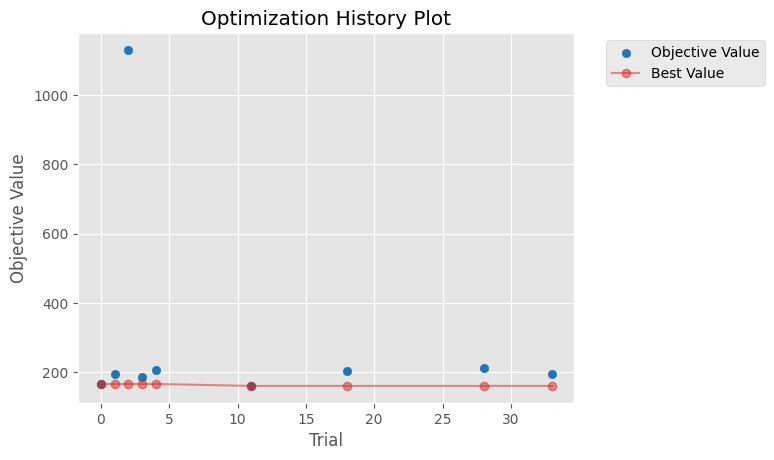

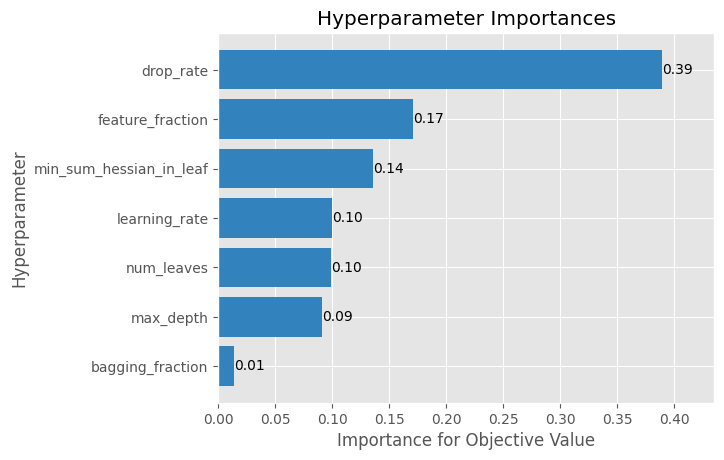

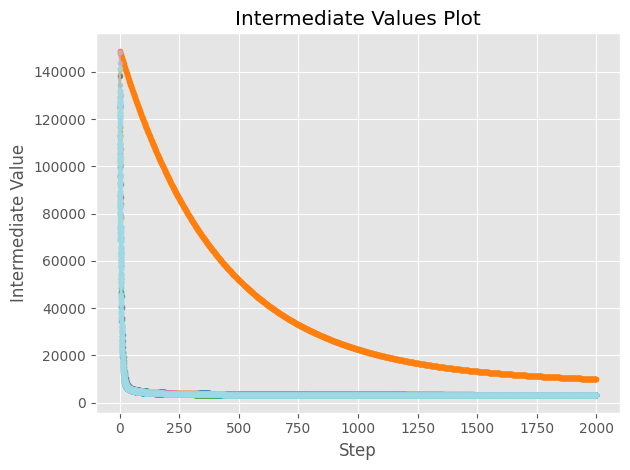

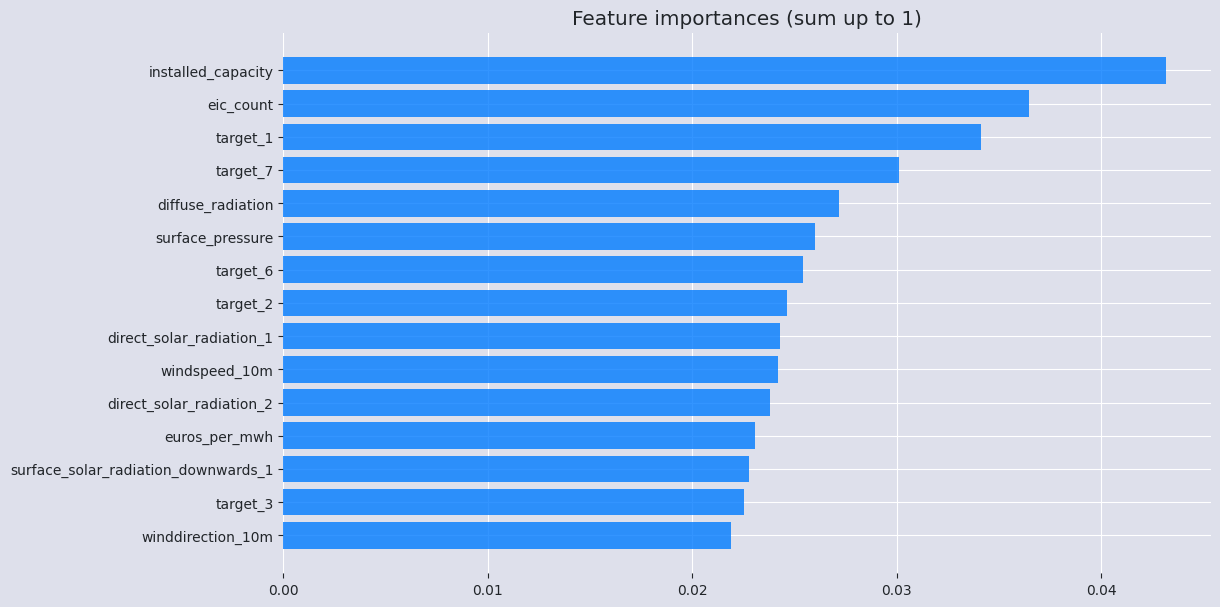


     . Optuna hyperparameters optimization finished
     .. Best trial number:11    |     rmspe:           160.87314251753514
 ---------------------------------------------------------------------------

Time elapsed for fit execution: 14 min 12.136 sec

   - Fitting optimized model with the follwing params:
learning_rate                    : 0.09978780698687728
num_leaves                       : 245
feature_fraction                 : 0.8348059892345406
bagging_fraction                 : 0.7834568285696684
verbosity                        : -1
random_state                     : 42
device_type                      : cpu
objective                        : regression
metric                           : l2
num_threads                      : 6
min_sum_hessian_in_leaf          : 9.884544011203282
max_depth                        : 73
drop_rate                        : 0.07010974258955846
num_iterations                   : 2000
Mean Absolute Error for is_consumption=0: 11.343526867594907


In [ ]:


import time
start_time = time.time()
# Initialize tuner for each set of input_dat  a
tuner = LGBMTuner(metric='rmspe', trials=50, refit=True, verbosity=1, visualization=True, seed=414243, device_type='cpu', grid='h,learning_rate')

# Define parameter ranges
tuner.grid['max_depth'] = (0, 100)
tuner.grid['learning_rate'] = (0.00001, 0.1)
tuner.grid['drop_rate'] = (0.05, 0.4)

# Fit tuner for each set of input_data
tuner.fit(X_train_0, y_train_0.squeeze())


# Fit optimized using the best hyperparameters
tuner.fit_optimized(X_train_0.to_numpy(), y_train_0.squeeze().to_numpy())

# Make predictions
y_pred_0 = tuner.predict(X_test_0)

# Calculate mean absolute error
mae_0 = mean_absolute_error(y_test_0, y_pred_0)

print(f'Mean Absolute Error for is_consumption=0: {mae_0}')

# Calculate the time taken to load the file
#time_taken_gpu = end_time - start_time
#print(time_taken_gpu)

 for target = 1



 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 50 trials
     .. Evaluation metric: rmspe 
     .. Study direction: minimize rmspe

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmspe: 4.310710239049001
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmspe: 20.293732208817616
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmspe: 128.51654498921962
 ...........................................................................
     . Trial number: 3 finished
     .. Optimization score (lower-better): rmspe: 2.636448022013153
 ...........................................................................
     . Trial number: 4 finished
     .. Optimization score (lower-better): rmspe: 8.72395397589504
 ............................................

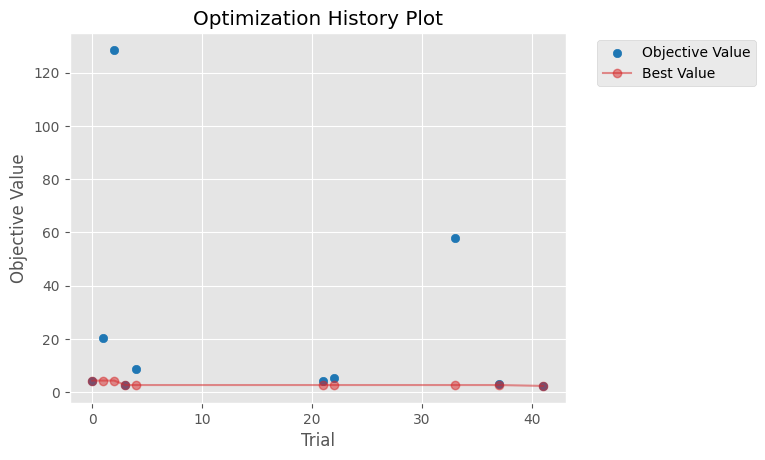

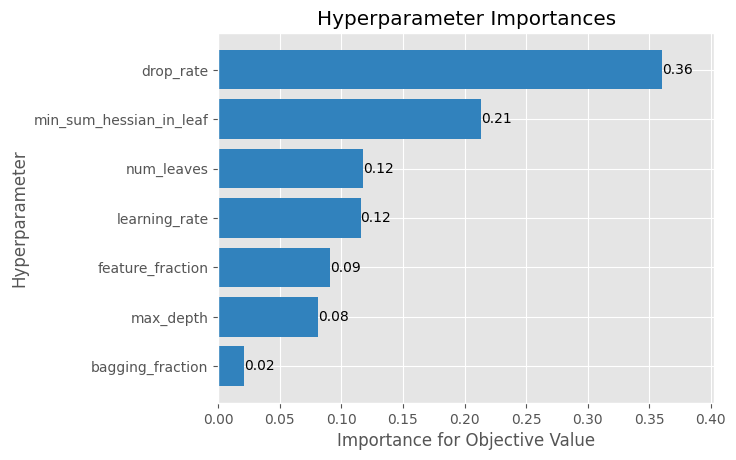

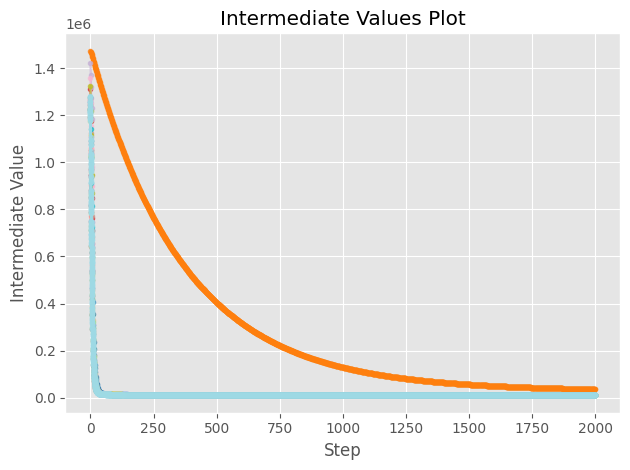

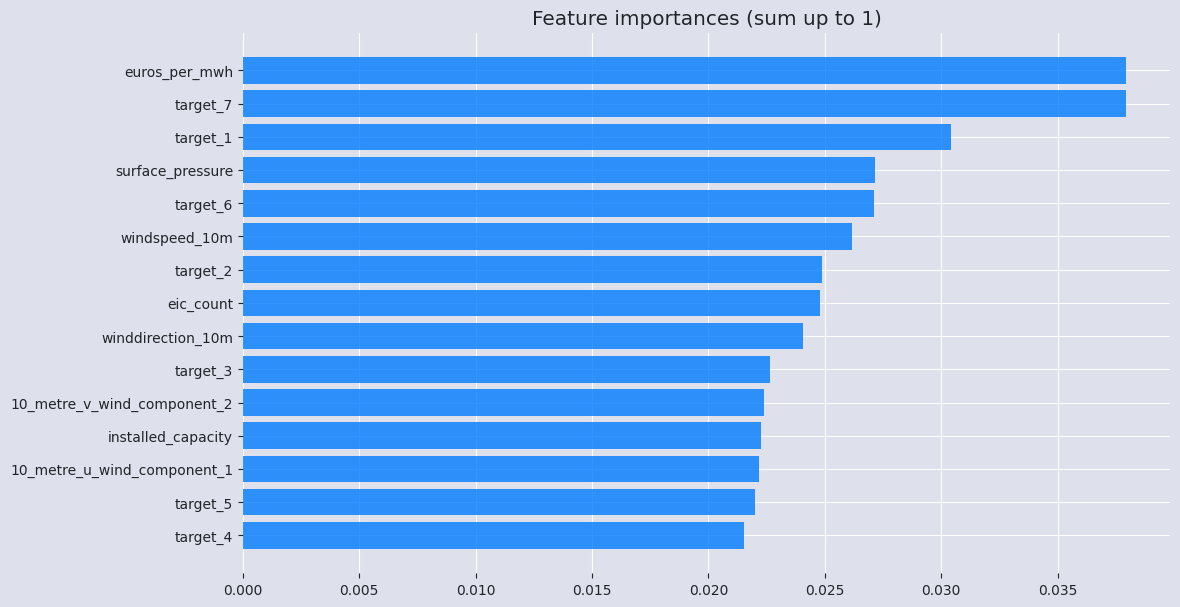


     . Optuna hyperparameters optimization finished
     .. Best trial number:41    |     rmspe:           2.3029468716192274
 ---------------------------------------------------------------------------

Time elapsed for fit execution: 21 min 8.245 sec

   - Fitting optimized model with the follwing params:
learning_rate                    : 0.0889859107083297
num_leaves                       : 255
feature_fraction                 : 0.7122025239754528
bagging_fraction                 : 0.8593116895508144
verbosity                        : -1
random_state                     : 42
device_type                      : cpu
objective                        : regression
metric                           : l2
num_threads                      : 6
min_sum_hessian_in_leaf          : 7.056629212937027
max_depth                        : 93
drop_rate                        : 0.09614444275629733
num_iterations                   : 2000
Mean Absolute Error for is_consumption=0: 31.883498990599726


In [ ]:


import time
start_time = time.time()
# Initialize tuner for each set of input_dat  a
tuner = LGBMTuner(metric='rmspe', trials=50, refit=True, verbosity=1, visualization=True, seed=414243, device_type='cpu', grid='h,learning_rate')

# Define parameter ranges
tuner.grid['max_depth'] = (0, 100)
tuner.grid['learning_rate'] = (0.00001, 0.1)
tuner.grid['drop_rate'] = (0.05, 0.4)

# Fit tuner for each set of input_data
tuner.fit(X_train_1, y_train_1.squeeze())


# Fit optimized using the best hyperparameters
tuner.fit_optimized(X_train_1.to_numpy(), y_train_1.squeeze().to_numpy())

# Make predictions
y_pred_1 = tuner.predict(X_test_1)

# Calculate mean absolute error
mae_1 = mean_absolute_error(y_test_1, y_pred_1)

print(f'Mean Absolute Error for is_consumption=0: {mae_1}')

# Calculate the time taken to load the file
#time_taken_gpu = end_time - start_time

more trails


 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 100 trials
     .. Evaluation metric: rmspe 
     .. Study direction: minimize rmspe

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmspe: 79.33994863711588
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmspe: 4.504073586260833
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmspe: 27.89804419917042
 ...........................................................................
     . Trial number: 3 finished
     .. Optimization score (lower-better): rmspe: 25.896448371384686
 ...........................................................................
     . Trial number: 4 finished
     .. Optimization score (lower-better): rmspe: 4.64597456584101
 ............................................

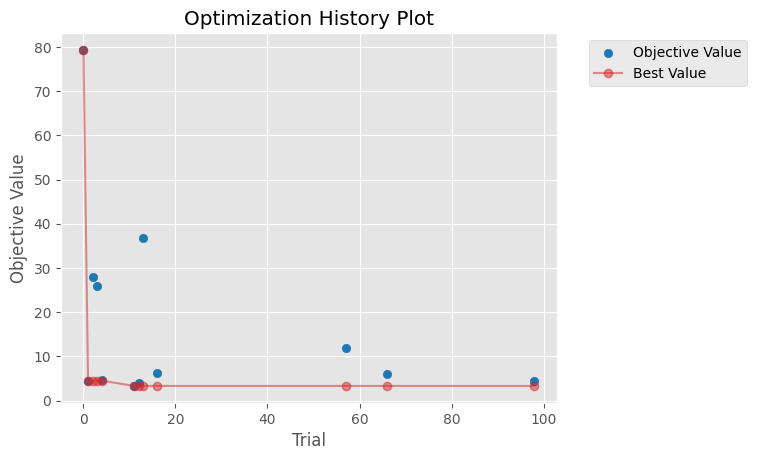

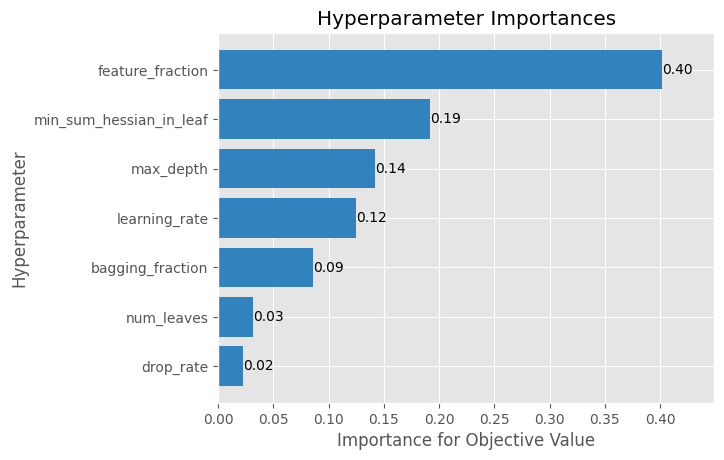

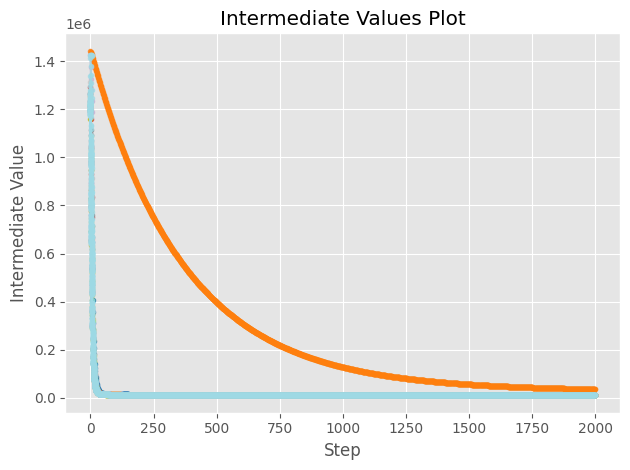

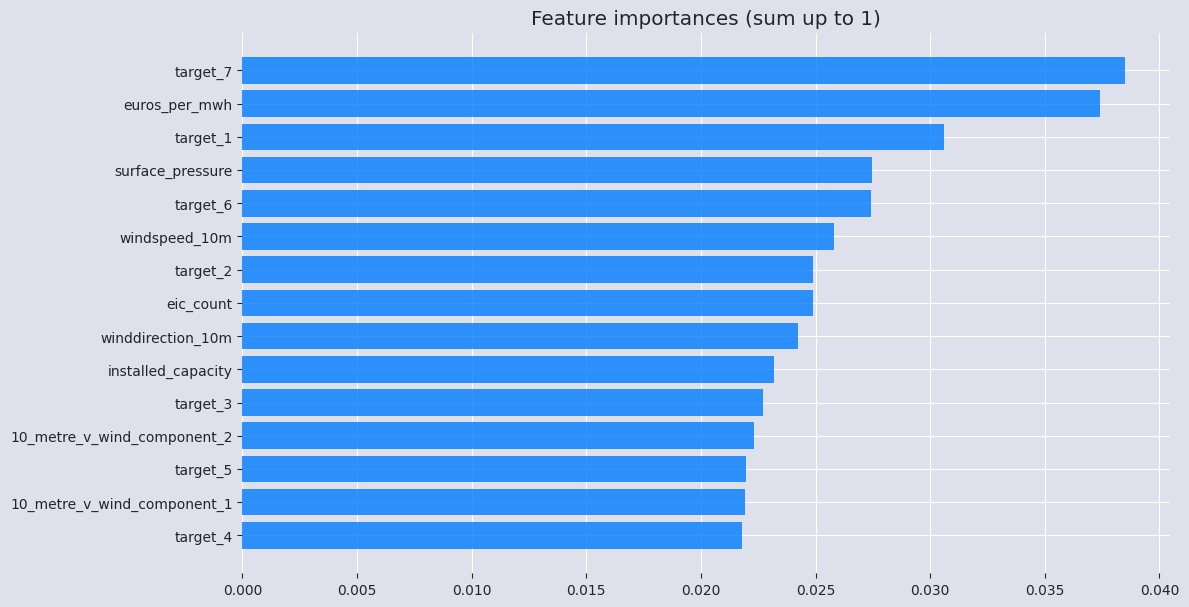


     . Optuna hyperparameters optimization finished
     .. Best trial number:11    |     rmspe:           3.3130086966354364
 ---------------------------------------------------------------------------

Time elapsed for fit execution: 30 min 57.692 sec

   - Fitting optimized model with the follwing params:
learning_rate                    : 0.09987911994397898
num_leaves                       : 245
feature_fraction                 : 0.7017652979291573
bagging_fraction                 : 0.8701181126111017
verbosity                        : -1
random_state                     : 42
device_type                      : cpu
objective                        : regression
metric                           : l2
num_threads                      : 6
min_sum_hessian_in_leaf          : 0.33654907398322953
max_depth                        : 42
drop_rate                        : 0.07010974258955846
num_iterations                   : 2000
Mean Absolute Error for is_consumption=0: 31.890887935172913


In [ ]:


import time
start_time = time.time()
# Initialize tuner for each set of input_dat  a
tuner = LGBMTuner(metric='rmspe', trials=100, refit=True, verbosity=1, visualization=True, seed=414243, device_type='cpu', grid='h,learning_rate')

# Define parameter ranges
tuner.grid['max_depth'] = (0, 100)
tuner.grid['learning_rate'] = (0.00001, 0.1)
tuner.grid['drop_rate'] = (0.05, 0.4)

# Fit tuner for each set of input_data
tuner.fit(X_train_1, y_train_1.squeeze())


# Fit optimized using the best hyperparameters
tuner.fit_optimized(X_train_1.to_numpy(), y_train_1.squeeze().to_numpy())

# Make predictions
y_pred_1 = tuner.predict(X_test_1)

# Calculate mean absolute error
mae_1 = mean_absolute_error(y_test_1, y_pred_1)

print(f'Mean Absolute Error for is_consumption=0: {mae_1}')

# Calculate the time taken to load the file
#time_taken_gpu = end_time - start_time

more

# Own Optuna test

In [ ]:
pip install lightgbm optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.8 MB/s eta 0:00:00


In [ ]:
import time
import optuna

In [ ]:
def objective(trial, X_train, y_train, X_test, y_test):
    param = {
        'objective': 'regression',
        'metric': 'l2',  # RMSPE not directly available, using l2 as a placeholder
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'max_depth': trial.suggest_int('max_depth', 0, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.00001, 0.1),
        'drop_rate': trial.suggest_float('drop_rate', 0.05, 0.4),
        'seed': 414243,
    }

    model = LGBMRegressor(**param)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)])
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    return mae

start_time = time.time()

study_0 = optuna.create_study(direction='minimize')
study_0.optimize(lambda trial: objective(trial, X_train_0, y_train_0, X_test_0, y_test_0), n_trials=50)

study_1 = optuna.create_study(direction='minimize')
study_1.optimize(lambda trial: objective(trial, X_train_1, y_train_1, X_test_1, y_test_1), n_trials=50)

end_time = time.time()
time_taken = end_time - start_time

print(f"Time taken for tuning: {time_taken} seconds")

# Train final models with best hyperparameters
best_params_0 = study_0.best_params
best_params_0.update({'objective': 'regression', 'metric': 'l2', 'verbosity': -1, 'boosting_type': 'gbdt'})
model_0 = LGBMRegressor(**best_params_0)
model_0.fit(X_train_0, y_train_0)

best_params_1 = study_1.best_params
best_params_1.update({'objective': 'regression', 'metric': 'l2', 'verbosity': -1, 'boosting_type': 'gbdt'})
model_1 = LGBMRegressor(**best_params_1)
model_1.fit(X_train_1, y_train_1)

# Make predictions
y_pred_0 = model_0.predict(X_test_0)
y_pred_1 = model_1.predict(X_test_1)

# Evaluate the models using mean_absolute_error
mae_0 = mean_absolute_error(y_test_0, y_pred_0)
mae_1 = mean_absolute_error(y_test_1, y_pred_1)

print(f'Mean Absolute Error for is_consumption=0: {mae_0}')
print(f'Mean Absolute Error for is_consumption=1: {mae_1}')

[I 2024-06-01 10:40:16,099] A new study created in memory with name: no-name-a968d043-c053-4f7c-865a-1eb312bb7f09
[I 2024-06-01 10:40:21,228] Trial 0 finished with value: 89.30578743566171 and parameters: {'max_depth': 97, 'learning_rate': 0.005125684094141064, 'drop_rate': 0.2874869172492256}. Best is trial 0 with value: 89.30578743566171.
[I 2024-06-01 10:40:26,798] Trial 1 finished with value: 27.78220769234267 and parameters: {'max_depth': 81, 'learning_rate': 0.029562837078514734, 'drop_rate': 0.11087317882152042}. Best is trial 1 with value: 27.78220769234267.
[I 2024-06-01 10:40:32,287] Trial 2 finished with value: 28.869204804121026 and parameters: {'max_depth': 16, 'learning_rate': 0.02759481782894117, 'drop_rate': 0.11314464141097101}. Best is trial 1 with value: 27.78220769234267.
[I 2024-06-01 10:40:37,468] Trial 3 finished with value: 20.589891416446765 and parameters: {'max_depth': 11, 'learning_rate': 0.0996162175757494, 'drop_rate': 0.09876612297246828}. Best is trial 3

KeyboardInterrupt: 